# CHAPTER 8. Demensionality Reduction

많은 머신러닝 문제들은 각각의 트레이닝 인스턴스에 대한 수천 또는 수백만개의 특징점을 포함하고있다.

그 문제점들은 트레이닝을 매우 느리게 할 뿐만 아니라, 좋은 해결을 찾기에 더 힘들게 만들 수 있다.

이 문제는 _curse of dimensionality_ 로 종종 언급된 것이다.

다행히도, 현실세계의 문제에서, _curse of dimensionality_ 는 다루기 힘든 문제를 다루기 쉬운 것으로 바꾸면서 특징점들의 수를 상당히 줄일 수 있다. 

Ex) MNIST 이미지를 고려해보면, 이미지 경계선에 있는 픽셀은 거의 흰색 -> 이 픽셀들을 학습 set으로부터 정보손실 없이 완전히 drop할 수 있다.

7장에서 본 그림 7-6은 분류 작업을 위해 이 픽셀들이 완전히 중요하지 않다라는 것을 확인 했다. 게다가, 두개의 이웃한 픽셀은 종종 높은 상관관계가 있다. 두개의 이웃한 픽셀을 하나의 픽셀로 병합한다면, 많은 정보를 잃게 될 것이다.
 

차원 축소(demensionality reduction)는 데이터 시각화(_DataViz_)에 매우 유용

차원의 수를 2개나 3개로 축소 -> 높은 차원의 트레이닝 set를 그래프로 나타내거나, cluster와 같은 시각적인 패턴을 감지해 중요한 통찰력을 얻을 수 있음

이번 8장에서

1. 차원의 저우에 대해 논의하고, 높은 차원의 공간에서 일어나는 일에 대해 이해
2. 다음 차원 감소에 대한 두 가지 주요 접근 방식(projection and Manifold Learning)을 제시하고, 가장 널리 사용되는 차원 축소 기술 중 세 가지(PCA, Kenel PCA, LLE)를 살펴 봄


In [12]:
# setup code

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 1. The Curse of Dimensionality


우리는 3차원 공간 -> 더 높은 차원의 이미지를 이해하는 것 어렵!


대부분의 학습 인스턴스는 서로 멀리 떨어져있을 가능성이 큼 -> 이는 또한 새로운 인스턴스가 학습 인스턴스와 멀리 떨어져있을 가능성이 높다는 것을 의미 -> 훨씬 더 큰 추가 프로젝트를 기반으로하기 때문에 하위 차원보다 예측이 훨씬 덜 신뢰



차원이 늘어날수록, 같은 비율(%)의 공간을 채우기 위해 인스턴스 1개당 필요한 데이터 양이 급격히 증가!

-> 차원이 높아질 수록, 가지고 있는 데이터 양이 (차원에 비해) 상대적으로 부족

-> 적은 데이터로 공간을 설명해야 하기 때문에, overfit문제 발생

-> 모델의 성능이 떨어짐 = generalizaion 이 안됨!!!


차원의 저주를 해결하는 방법 중 하나 -> 훈련 인스턴스의 충분한 밀도에 도달하도록 트레이닝 set의 크기를 증가시킴 

# 2. Main Approaches for Dimensionality Reduction

차원 축소 알고리즘을 보기 전에, 두가지의 메인 차원 축소의 접근법(_projection & manifold learning_)을 살펴보자!



## 2.1 Projection

현실세계에서, 트레이닝 인스턴스는 모든 차원에 걸쳐 균일하게 분산되어 있지 않다.

그 결과, 모든 트레이닝 인스턴스는 사실상 고차원의 훨씬 더 낮은 차원의 _부분 공간(subspace)_ 안에 놓여있다.

그 예는 그림 8-2에서 원으로 표현된 3D 데이터 set으로 볼 수 있다.


In [53]:
#Draw 3D arrows

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [14]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

그림 8-2을 보면, 3D의 부분공간, 2D에 학습 인스턴스들이 평면으로 누워있음

만약 모든 트레이닝 인스턴스들을 수직적으로 subspace에 투사(projection)해본다면, 그림 8-3과 같은 2D 데이타 set을 볼 수 있다!

차원을 3D -> 2D 

새로운 feature z_1, z_2

하지만 projection이 차원축소의 가장 좋은 접근 방법은 아님

아래 그림과 같이, 부분공간의 많은 경우는 꼬여있거나 돌아가있다. (_Swiss roll_ toy dataset)

In [15]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


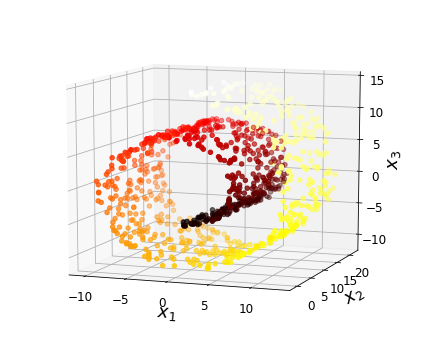

In [16]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

Saving figure squished_swiss_roll_plot


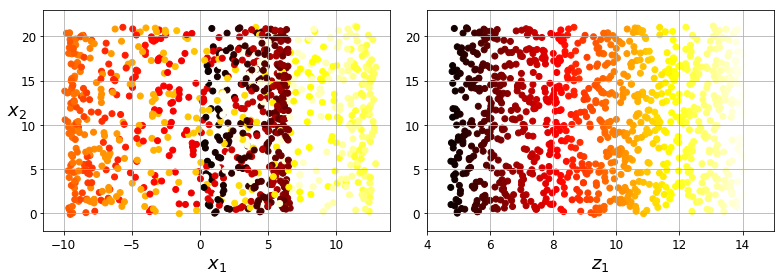

In [17]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()


간단하게 평면으로 투사하는 것은 다른 레이어에 함께 뒤틀릴 수 있다. (왼쪽 그림)

하지만, 정말 우리가 원하는 것은 오른쪽 그림과 같은 데이터 set을 얻는 것이다!

## 2.2 Manifold Learning

Swiss roll 은 2D _manifold_ 의 예제

2D의 manifold는 높은 차원의 공간에서 구부러지거나 꼬여질 수 있는 2D 모양

_d_ 차원 manifold는 지역적으로 _d_ 차원 초평면과 닮은 _n_ 차원 공간의 부분 (d<n)

Swiss roll의 경우 d=2, n=3
-> 지역적으로 2D 평면과 닮았지만, 세번째 차원에서 roll된다!




_Manifold Learning_ : 많은 차원 축소 알고리즘은 훈련 인스턴스가 놓여있는 _manifold_ 를 모델링하여 작동

* 실제 세계의 고차원 데이터 set이 훨씬 더 낮은 차원의 manifold에 가깝도록 놓여있는 _manifold assumption(manifold hypothesis)_ 에 의존

    이 가정은 종종 경험적으로 관찰 됨.



MNIST 데이터를 생각해보자!

모든 손으로 쓰여진 숫자 이미지는 서로 유사함 (이미지들은 연결된 선들로 이루어져 있고, 테두리는 흰색이고, 중심에 있는 등등)

만약 랜덤하게 섞는다면, 이미지의 작은 조각들은 손으로 쓰여진 숫자 처럼 보임

즉, 숫자 이미지를 만들려고 할 때 사용할 수있는 자유도는 원하는 이미지를 생성 할 수있는 자유도보다 훨씬 낮음

이러한 제약은 데이터 집합을 더 낮은 차원의 manifold로 집어 넣는 경향이 있음.


_(?)_


manifold 가정은 종종 다른 절대적인 가정에 의해 동행되어짐

manifold의 더 낮은 차원 공간에서 표현된다면 더 손쉽게 진행될 것이다.

Ex) 그림 8-6 1번째 행 : (왼쪽) 3D 공간으로, 결정경계가 상당히 복잡, (오른쪽) 2D unrolled manifold 공간으로, 결정경계가 매우 단순한 직선


Ex) 그림 8-6 2번째 행 : (왼쪽) 결정 경계가 x_1=5 에 위치, 
이 결정경계는 원래의 3D 공간에서 매우 간단해 보이지만, (오른쪽) unrolled manifold에서는 더 복잡하게 보임!!


However, 이 가정은 항상 일정하지 않다!

간단히 말하면, 모델을 학습시키기 전 학습 set의 차원을 줄이게 된다면, 학습 속도는 증가하게 될 것이지만, 이것이 항상 좋은 방법은 아니다.

-> 데이터 set에 모두 결정된다!!



Saving figure manifold_decision_boundary_plot1


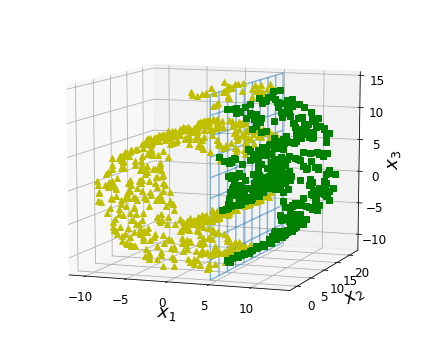

Saving figure manifold_decision_boundary_plot2


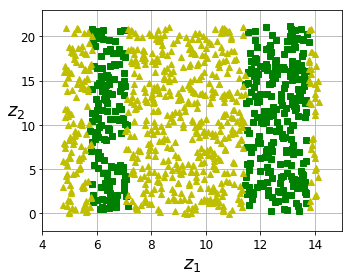

Saving figure manifold_decision_boundary_plot3


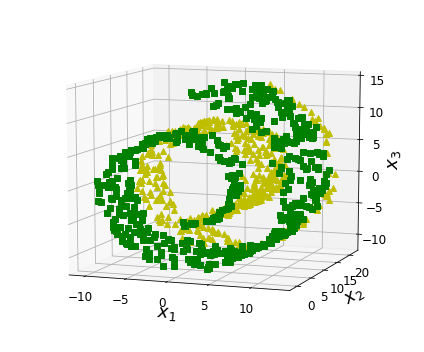

Saving figure manifold_decision_boundary_plot4


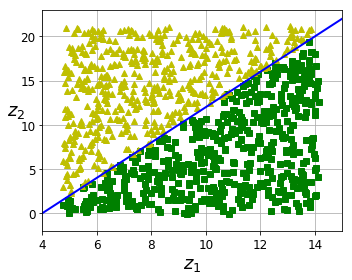

In [18]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

# 3. PCA

_Principal Component Analysis (PCA)_ 

* 가장 널리 사용되는 차원 축소 알고리즘

* 먼저 데이터에 가장 가까운 놓여있는 초평면을 식별 한 다음 데이터를 그 위에 투영

## 3.1 Preserving the Variance

트레이닝 셋을 낮은 차원 초평면위에 투영하기 전, 먼저 정확한 초평면을 선택해야함

ex) 간단한 2D 데이터 set은 3개의 다른 축과 함께 아래 그림의 왼쪽으로 보여진다

Saving figure pca_best_projection


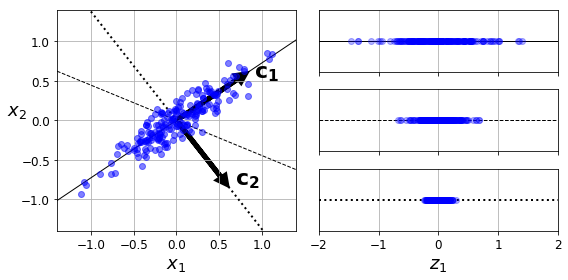

In [19]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection")
plt.show()

오른쪽 그림 -> 데이터set을 각각 3가지 축 위로 투영한 결과

실선으로의 투사는 최대 분산을 유지하지만, 점선으로의 투영은 매우 적은 분산을 유지하고, 점선으로의 투영은 중간의 분산을 보존합니다.

실선으로의 투영 : 최대 분산 유지

점선으로의 투영 : 매우 적은 분산 유지

dach line 으로의 투영 : 중간 분산을 유지

    분산의 최대 값을 유지하는 축을 선택하는 것이 합리적  ->  다른 투영보다 정보가 거의 손실되지 않기 때문!!





또 다른 방법

-> 원래의 데이터 세트와 그 축으로의 투영 사이의 평균 제곱 거리를 최소화하는 축 -> PCA의 간단한 idea


## 3.2 Principal Components

PCA는 학습 set에서 가장 큰 분산을 설명하는 축을 식별 -> 위 그림에서, 실선을 의미한다!

또한, 첫 번째 축과 직각을 이루는 가장 큰 양의 나머지 분산을 설명하는 두 번째 축을 찾는다. -> 점선을 의미

만약, 높은 차원의 데이터 셋이라면, PCA는 또한 이전 축과 직각 축 모두에 직각 인 세 번째 축과 네 번째 축, 다섯 번째 축 등을 찾는다.

데이터 집합의 차원 수만큼 축을 정렬합니다.

i번째 축을 정의하는 단위 벡터를 i번째 _principal component (PC)_ 이라고 부른다.

위의 그림에서, 1st PC는 c_1이고, 2nd PC는 c_2 다.


그렇다면 학습 set에서 어떻게 principal components를 찾을 수 있을까?

-> _Singular Value Decomposition (SVD)_ 라고 불리는 표준행렬인수분해(standard matrix factorization) 라는 기술이 있다!



아래 코드는, python코드로 NumPy's의 __svd()__ 함수를 사용

트레이닝 세트의 모든 주요 구성 요소를 얻은 다음 처음 두 PC를 추출

In [20]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

## 3.3 Projecting Down to d Dimensions

모든 주 성분(principal components)를 식별했다면, 첫 번째 주요 구성 요소로 정의 된 초평면에 투영하여 d 차원으로 데이터 집합의 차원을 줄일 수 있다.

이 초평면을 선택하면 투영이 가능한 많은 분산을 유지할 수 있다.

예를들어, 그림 8-2에서 3D 데이터 set은 처음 두 principal components에 의해 정의 된 2 차원 평면 아래로 투영되어, 데이터 set 분산의 상당 부분을 보존

그 결과로, 2D 투영은 원래의 3D 데이터 set와 매우 흡사!

트레이닝 set를 초평면에 투영하기위해, 트레이닝 set 행렬 X의 내적을 첫 번째 d principal components가 포함 된 행렬로 정의 된 행렬 W로 간단히 계산

아래는 첫번째로 두개의 principal components로 정의된 평면 위에 학습 set을 투영하는 python 코드이다.

In [21]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

## 3.4 Using Scikit-Learn

scikit-learn의 __PCA__ 클래스는 우리가 전에 한 것 처럼 SVD 분해를 사용하면서 PCA를 이행한다.

아래 코드는 데이터 set의 차원을 2차원으로 줄이기 위해 PCA를 적용한다.

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

__PCA__ 변환기를 데이터 set에 맞추면 __components___ 변수를 사용해, 주 구성 요소(principal components)에 접근 할 수 있다.

## 3.5 Explained Variance Ratio

매우 유용한 또 다른 정보는 __explained_variance_ratio__ 변수를 통해 사용할 수있는 각 주 구성 요소(principal components)의 _explained variance ratio(설명된 분산 비율)__ 이다.

각 주 구성 요소의 축을 따라있는 데이터 set의 분산 비율을 나타냄

예를들어, 그림 8-2 에 표시된 3d 데이터 set의 처음 두 구성 요소에 대한 설명 된 분산 비율을 살펴 보자.

In [23]:
pca.explained_variance_ratio_

array([ 0.95369864,  0.04630136])

The first dimension explains 95.3% of the variance, while the second explains 4.6%.

## 3.6 Choosing the Right Number of Dimensions

* 축소 할 차원 수를 임의로 선택하는 대신, 일반적으로 분산의 충분히 큰 부분까지 더하는 차원 수를 선택하는 것이 좋음

* 데이터 시각화를위한 차원을 줄이지 않는 한, 일반적으로 2, 3차원으로 줄이는 것이 좋음



아래 코드는 차원 축소 없이 PCA를 계산 -> 학습 set의 분산의 95%를 유지하는 데 필요한 최소 치수 수를 계산

In [24]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [25]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [27]:
d

154

그런 다음 __n_components = d__ 를 설정하고 PCA를 다시 실행

하지만, 보존하려는 주 구성 요소(principal components)의 수를 지정하는 대신, 

__n_components__ 를 0.0과 1.0 사이의 부동 소수점으로 설정하여 보존하려는 분산의 비율을 나타낼 수 있다!!

In [28]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [29]:
pca.n_components_

154

또 다른 옵션은 설명 된 분산을 차원 수의 함수로 plot

설명 된 분산이 빠르게 커지는 것을 멈추는 곡선에 보통 elbow가 있다.(그림 8-8)

이것을 데이터 set의 본질적인 차원으로 생각할 수 있다.

이 경우, 차원을 약 100 차원으로 줄이면 너무 많이 설명 된 분산을 잃지 않는다는 것을 알 수 있다!!


## 3.7 PCA for compression

차원 축소 후에, 트레이닝 set는 훨씬 적은 공간을 차지

예를들어, PCA를 MNIST 데이터 set에 적용 해보고 그 분산의 95%를 유지

-> 각 인스턴스에는 원래 784 feature 대신, 150개 정도의 feature만 있을 것

=> 따라서 대부분의 분산은 유지되지만, 데이터 set는 원래 크기의 20% 미만!!!


이것은 합리적인 압축비(reasonable sompression ratio)이며, 이것이 어떻게 분류 알고리즘(SVM 분류기)의 속도를 높일 수 있는지를 알 수 있다.

PCA 투영의 역변환(inverse transformation)을 적용해, 축소 된 데이터 세트 -> 다시 784 차원으로 압축을 풀기 가능!

당연히 이것은 투영법이 약간의 정보를 잃어 버렸기 때문에 원본 데이터를 되돌려주지는 못하지만, 원본 데이터와 매우 유사

 _reconstruction error(재구성 오류)_ : 원래 데이터와 재구성 된 데이터 간의 평균 제곱 거리
 
예를들어, 다음 코드는 MNIST 데이터 set을 154 차원으로 압축 -> __inverse_transform()__ 메서드를 사용해 이를 784 차원으로 다시 압축 풀기


In [30]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [31]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


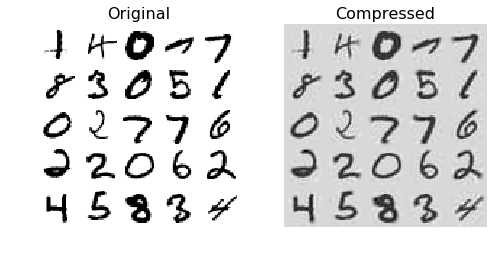

In [32]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

왼쪽 : 원래 훈련 세트

오른쪽 : 압축 -> 압축 해제


약간의 화질 손실이 있지만, 숫자는 거의 손상되지 않음!!

## 3.8 Incremental PCA

PCA의 이전 구현에서의 한 가지 문제점은 SVD 알고리즘을 실행하기 위해 전체 훈련 set가 메모리에 적합하도록 요구한다는 것

-> _Imcremental PCA(IPCA)_ 알고리즘이 개발

* 훈련 set을 mini-batch로 분할하고,IPCA 알고리즘에 한 번에 하나의 mini-batch를 공급할 수 있다

* 이것은 큰 학습 set 및 PCA 온라인을 적용하는 데 유용!

아래는 MNIST 데이터 set을 100개의 mini-batche로 분할하고, 

MNIST 데이터 set의 차원을 154차원까지 줄이기 위해 Sicit-Learn의 __IncrementalPCA__ 클래스를 제공한 코드

*전체 학습 set를 사용하여 __fit()__ 메소드 대신, 각 mini-batch로 __partial_fit()__ 메소드를 호출해야함!*

In [33]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

선택적으로, Numpy의 __memmap__ 클래스를 사용 할 수 있다.

이 클래스를 사용하면 디스크에있는 이진 파일에 저장된 큰 배열을 마치 메모리에있는 것처럼 조작 할 수 있다.

이 클래스는 필요할 때, 메모리에 필요한 데이터 만 로드한다.

__IncrementalPCA__ 클래스는 배열의 작은 부분만 사용하기 때문에, 메모리 사용은 통제아래 있다.

-> 이것은 __fit()__ 방법을 부르는 것을 가능하게 하는데, 아래 코드에서 볼 수 있다!


In [34]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [35]:
del X_mm

In [36]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

## 3.9 Randomized PCA

* Scikit-Learn은 _Randomized PCA_ 라고 불리는 PCA의 다른 옵션을 제공

* Randomized PCA 는 첫번째 _d_ 주 구성 요소(principal components)의 접근을 빠르게 찾는 확률적인 알고리즘

* d가 n보다 매우 작을때, 기존의 알고리즘 보다 매우 빠름


In [37]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# 4. Kernel PCA

5장에서 논의한 kenel trick은 

Support Vector Machines 을 사용하여 인스턴스를 매우 고차원 공간으로 암시적으로 매핑하여 비선형 분류 및 회귀를 가능하게하는 수학적 기법

고차원 특징 공간에서의 선형 결정 경계는 원래 공간(_original space_)에서의 복잡한 비선형 결정 경계에 해당한다는 것을 상기! 



같은 tirck은 차원 축소를 위한 복잡한 비선형 투영을 수행하는 것을 가능하게 하면서, PCA로 적용 될 수 있다.

-> ___Kenel PCA(kPCA)___

* KPCA는 투영 후, 인스턴스의 클러스터를 보호하기 적합 

* 꼬여있는 manifold에 가깝게 있는 데이터 set을 unroll한다.

다음은 RBF 커널과 함께 kPCA를 수행하기 위해 Scikit-Learn의 __KernelPCA__ 클래스를 사용하는 예제 코드



In [38]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [39]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

아래 그림은 Swiss roll를 보여주는데, linear kernel, RBF kernel, sigmoid kernel 을 사용해 2차원으로 줄였다. 

Saving figure kernel_pca_plot


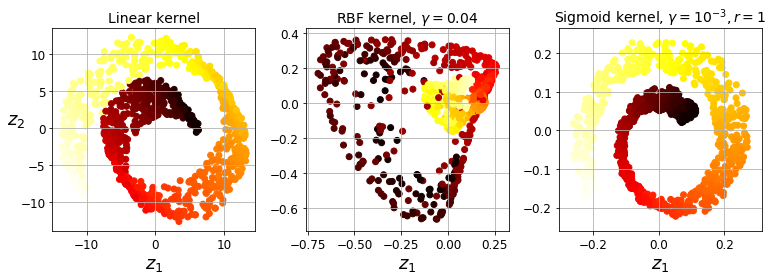

In [40]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

## 4.1 Selecting a Kernel and Tuning hyperparameters

kPCA는 비지도학습(unsupervised learning) 알고리즘으로써, 최적의 커널과 하이퍼파라미터의 값을 선택을 돕기위한 명확한 수행 측정이 없다.

하지만, 차원 축소는 지도학습 작업(ex.classification)을 수행하기 위한 예비단계!

-> 작업에 최적의 수행을 이끄는 커널과 하이퍼 파라미터를 선택하기 위한 그리드 서치를 간단하게 사용 할 수 있다!

예를 들어, 아래 코드는 두 단계의 파이프라인을 만든다. 

    1. kPCA를 사용해 2차원으로 차원을 축소
    2. 분류를 위해 Logistic Regression을 적용
    3. 파이프라인의 끝에서 최적의 분류 정확도를 얻기위해 kPCA를 위한 최적의 커널과 값을 찾는 __GridSearchCV__를 사용

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([ 0.03   ,  0.03222,  0.03444,  0.03667,  0.03889,  0.04111,
        0.04333,  0.04556,  0.04778,  0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

최적의 커널과 하이퍼 파라미터는 __best_prams__ 변수로 이용 가능

In [42]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


이번에는 전체적으로 비감독을 사용한 다른 접근방법은 가장 낮은 재구성 오차(reconstruction error)를 산출하는 커널과 하이퍼 파라미터를 선택

하지만, 재구성은 선형적인 PCA만큼 쉽지 않다. 

<그림 8-11>

왼쪽 위 : Swiss roll 3D 데이터 set

오른쪽 위 : kPCA가 RBF 커널을 사용하여 적용되어진 후, 2D 데이터 set 결과 

오른쪽 아래 : 커널 트릭 덕분에, _feature map_ 을 사용하여 학습 set을 무한 차원의 피쳐 공간에 매핑 한 다음,

선형 PCA를 사용하여 변형 된 트레이닝 세트를 2D로 투영하는 것과 수학적으로 동일

축소 된 공간에서 주어진 인스턴스에 대한 선형 PCA 단계를 invert 할 수 있다면, 재구성 된 point는 원래 공간이 아닌 feature 공간에 놓임

특징 공간은 무한 차원이기 때문에, 재구성 된 점을 계산할 수 없어 실제 재구성 오류(reconstrutrion error)를 계산할 수 없음

운 좋게도! 원래 공간에서 재구성 된 포인트에 가까운 포인트를 찾을 수 있음

-> 이것을 reconstruction _pre-image_ 라고 부른다!!

이 pre-image가 있으면, 원본 인스턴스와의 제곱 거리 측정 가능

=> 이 재구성 사전 이미지 오류(reconstruction pre-image error)를 최소화하는 커널 및 하이퍼 매개 변수를 선택할 수 있다



이 재구성을 하는 한가지 방법 - 훈련 된 set으로 투영 된 인스턴스와 목표로 원래의 인스턴스로 감독 된 회귀 모형을 훈련

아래 코드는 __fit_inverse_transform=True__ 로 하면, Scikit-Learn이 자동으로 이를 하게 해주는 것을 보여준다.



In [43]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

그런 다음 reconstruction pre-image error를 계산할 수 있다!

In [44]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766111

이제 cross-validation와 함께 그리드 검색을 사용해 pre-image 재구성 오류를 최소화화는 커널 및 하이퍼 매개변수를 찾을 수 있다!

# 5. LLE

* _Locally Linear Embedding(LLE)_ 는 매우 강력한 _nonlinear dimensionality reduction(NLDR)_ 기술이다!

* 매니폴드 러닝 기술로 이전의 알고리즘과 같은 투영에 의존하지 않는다

* 간단히 말해 LLE는 먼저 각 교육 인스턴스가 가장 가까운 이웃과 선형 적으로 관련되어 있는지 측정 한 다음, 이러한 로컬 관계가 가장 잘 유지되는 학습 set의 낮은 차원 표현을 찾는다.

* 특히 많은 잡음이 없을 때, 꼬인 매니 폴드를 풀 때 좋다!



예를들어, 아래 코드는 Swiss roll를 풀기위해 Scikit-Learn의 __LocallyLinearEmbedding__ 클래스를 사용했다.

In [45]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [89]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


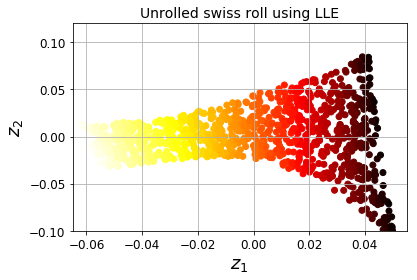

In [90]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

Swiss roll은 완전히 풀린 것은 볼 수 있고, 인스턴스간 거리는 지역적으로 잘 보존되어있다.

하지만, 거리는 큰 스케일에서는 보존되지 않았다 : 풀린 swiss roll의 왼쪽 부분은 squeeze되어졌다. 
                                
                                                오른쪽 부분은 뻗어져있다



어떻게 LLE가 작동하나?!

* 
* 

각각의 학습 인스턴스 __x^(i)__ 에 대해, 알고리즘은 k 개의 가장 가까운 이웃을 식별하고,

__x^(i)__ 를 이들 이웃의 선형 함수로서 재구성하려고 시도한다.

더 구체적으로, __x^(i)__ 와 sigma w_i,j* x^(j) 사이의 제곱 거리가 가능한 한 작게되도록 w_i,j를 찾는다. (__x^(i)__ 가 __x^(i)__ 의 가장 가까운 이웃 중 k가 아닌 경우 w_i,j=0 로 가정)

* 따라서 LLE의 첫 번째 단계는 식 8-4에서 설명 된 제약 된 최적화 문제(constrained optimaization)이다. 

    여기서 __W__ 는 모든 가중치 w_i,j를 포함하는 가중치 행렬이다. 

    두 번째 제약은 단순히 각 training instace __x^(i)__ 에 대한 가중치를 정규화했다.

이 과정이 끝난 후에, ___W___ 는 트레이닝 인스턴스 간의 로컬 선형 관계를 설명

* 이제 두 번째 단계는 훈련 장소를 d 차원 공간(d<n)으로 매핑하면서 가능하면 이 지역 관계를 유지.

    __z^(i)__ 이 d-차원 공간에서의 __x^(i)__ 의 이미지인 경우, __z^(i)__ 와 sigma w_i,j* z^(i) 간의 제곱 된 거리를 최대한 작게 한다

    이 아이디어는 수식 8-5에서 설명 된 제약되지 않은 최적화 문제(unconstrained optimization prolem)로 이어진다.

    첫 번째 단계와 매우 유사하게 보이지만, 인스턴스를 고정시키고 최적의 가중치를 찾는 대신, 가중치를 고정시키고 저 차원 공간에서 인스턴스 이미지의 최적 위치를 찾는 것과 반대의 작업을 수행
    
__Z__ 는 모든 z^(i)를 포함하는 행렬 

# 6. Other Dimensionality Reduction Techniques

많은 차원축소 기술이 있다. 그들 중 몇가지는 Scikit-Learn으로 사용 가능하다!

In [48]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [49]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/home/soyeon/sy/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Saving figure other_dim_reduction_plot


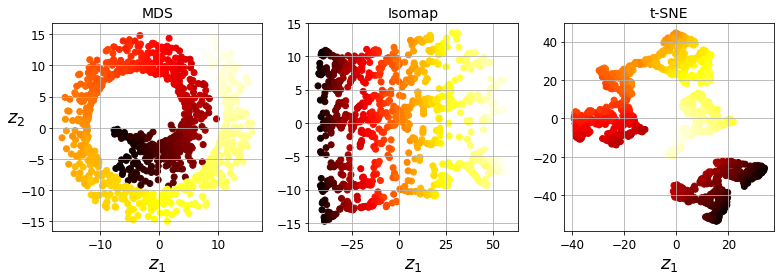

In [52]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

* _Multidimensional Scaling (MDS)_ 는 인스턴스간의 거리를 유지하면서 차원 감소 (위 그림 중 왼쪽)


* _Isomap_ 은 각각의 인스턴스를 가까운 이웃 인스턴스와 연결하면서 그래프를 만든다. 그런 다음,  인스턴스 간의 _geodesic distances_ 를 유지하면서 차원 감소 (위 그림 중 가운데)


* _t-Distributed Stochastic Neighbor Embeding (t-SNE)_ 비슷한 인스턴스를 가깝게, 비슷하지 않은 인스턴스는 멀게 하면서 차원을 축소 이것은 주로 시각화, 특히 고차원 공간에서 인스턴스의 클러스터를 시각화하는 데 사용 됨 (위 그림 중 오른쪽)


* _Linear Discriminant Analysis (LDA)_ 는 사실 분류 알고리즘이다. 하지만 이것을 학습시키는 동안 클래스 사이의 가장 차별적인 축을 학습하고, 이 축을 사용해 데이터를 투영 할 초평면을 정의할 수 있다!
    이 점은 투영이 클래스를 최대한 멀리 유지할 것이므로, LDA는 SVM classifier와 같은 다른 분류 알고리즘을 실행하기 전에 차원을 축소하는 좋은 기술!